## 按照时间维度对数据集进行切分

In [7]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 先进行控制变量实验 验证模型的有效性

In [8]:
# 准备数据集
from utils import *
from collections import Counter

data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_ramdom = data_csv.sample(frac=1, random_state=1).reset_index(drop=True)

data_1 = data_ramdom[: 6929]
data_2 = data_ramdom[6929: 9597]
data_3 = data_ramdom[9597: ]
print(data_1.shape, data_2.shape, data_3.shape)

print(Counter(data_1['label']))
print(Counter(data_2['label']))
print(Counter(data_3['label']))

(6929, 9) (2668, 9) (3878, 9)
Counter({'virus': 1859, 'trojan': 1842, 'worm': 1761, 'backdoor': 1467})
Counter({'trojan': 732, 'virus': 700, 'worm': 677, 'backdoor': 559})
Counter({'virus': 1041, 'trojan': 1026, 'worm': 1021, 'backdoor': 790})


In [9]:
data_path_1, labels_1 = path_loader(data_1)
data_path_2, labels_2 = path_loader(data_2)
data_path_3, labels_3 = path_loader(data_3)

In [10]:
# 加载数据并进行训练
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential, metrics
from tensorflow.keras import Input, Model, regularizers
from malconv import get_malconv


batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(31)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(31)

model = get_malconv()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(db_train,
                    epochs=30,
                    steps_per_epoch=46,
                    validation_data=db_val,
                    validation_steps=30)

Epoch 1/30
46/46 [==============================] - 558s 12s/step - loss: 1.9040 - categorical_accuracy: 0.5616 - val_loss: 0.9449 - val_categorical_accuracy: 0.9172
Epoch 2/30
46/46 [==============================] - 511s 11s/step - loss: 0.8200 - categorical_accuracy: 0.9305 - val_loss: 0.5185 - val_categorical_accuracy: 0.9740
Epoch 3/30
46/46 [==============================] - 488s 11s/step - loss: 0.5007 - categorical_accuracy: 0.9648 - val_loss: 0.3473 - val_categorical_accuracy: 0.9883
Epoch 4/30
46/46 [==============================] - 500s 11s/step - loss: 0.3377 - categorical_accuracy: 0.9816 - val_loss: 0.2581 - val_categorical_accuracy: 0.9924
Epoch 5/30
46/46 [==============================] - 503s 11s/step - loss: 0.2518 - categorical_accuracy: 0.9903 - val_loss: 0.2004 - val_categorical_accuracy: 0.9977
Epoch 6/30
46/46 [==============================] - 504s 11s/step - loss: 0.1944 - categorical_accuracy: 0.9975 - val_loss: 0.1665 - val_categorical_accuracy: 0.9995
Epoc

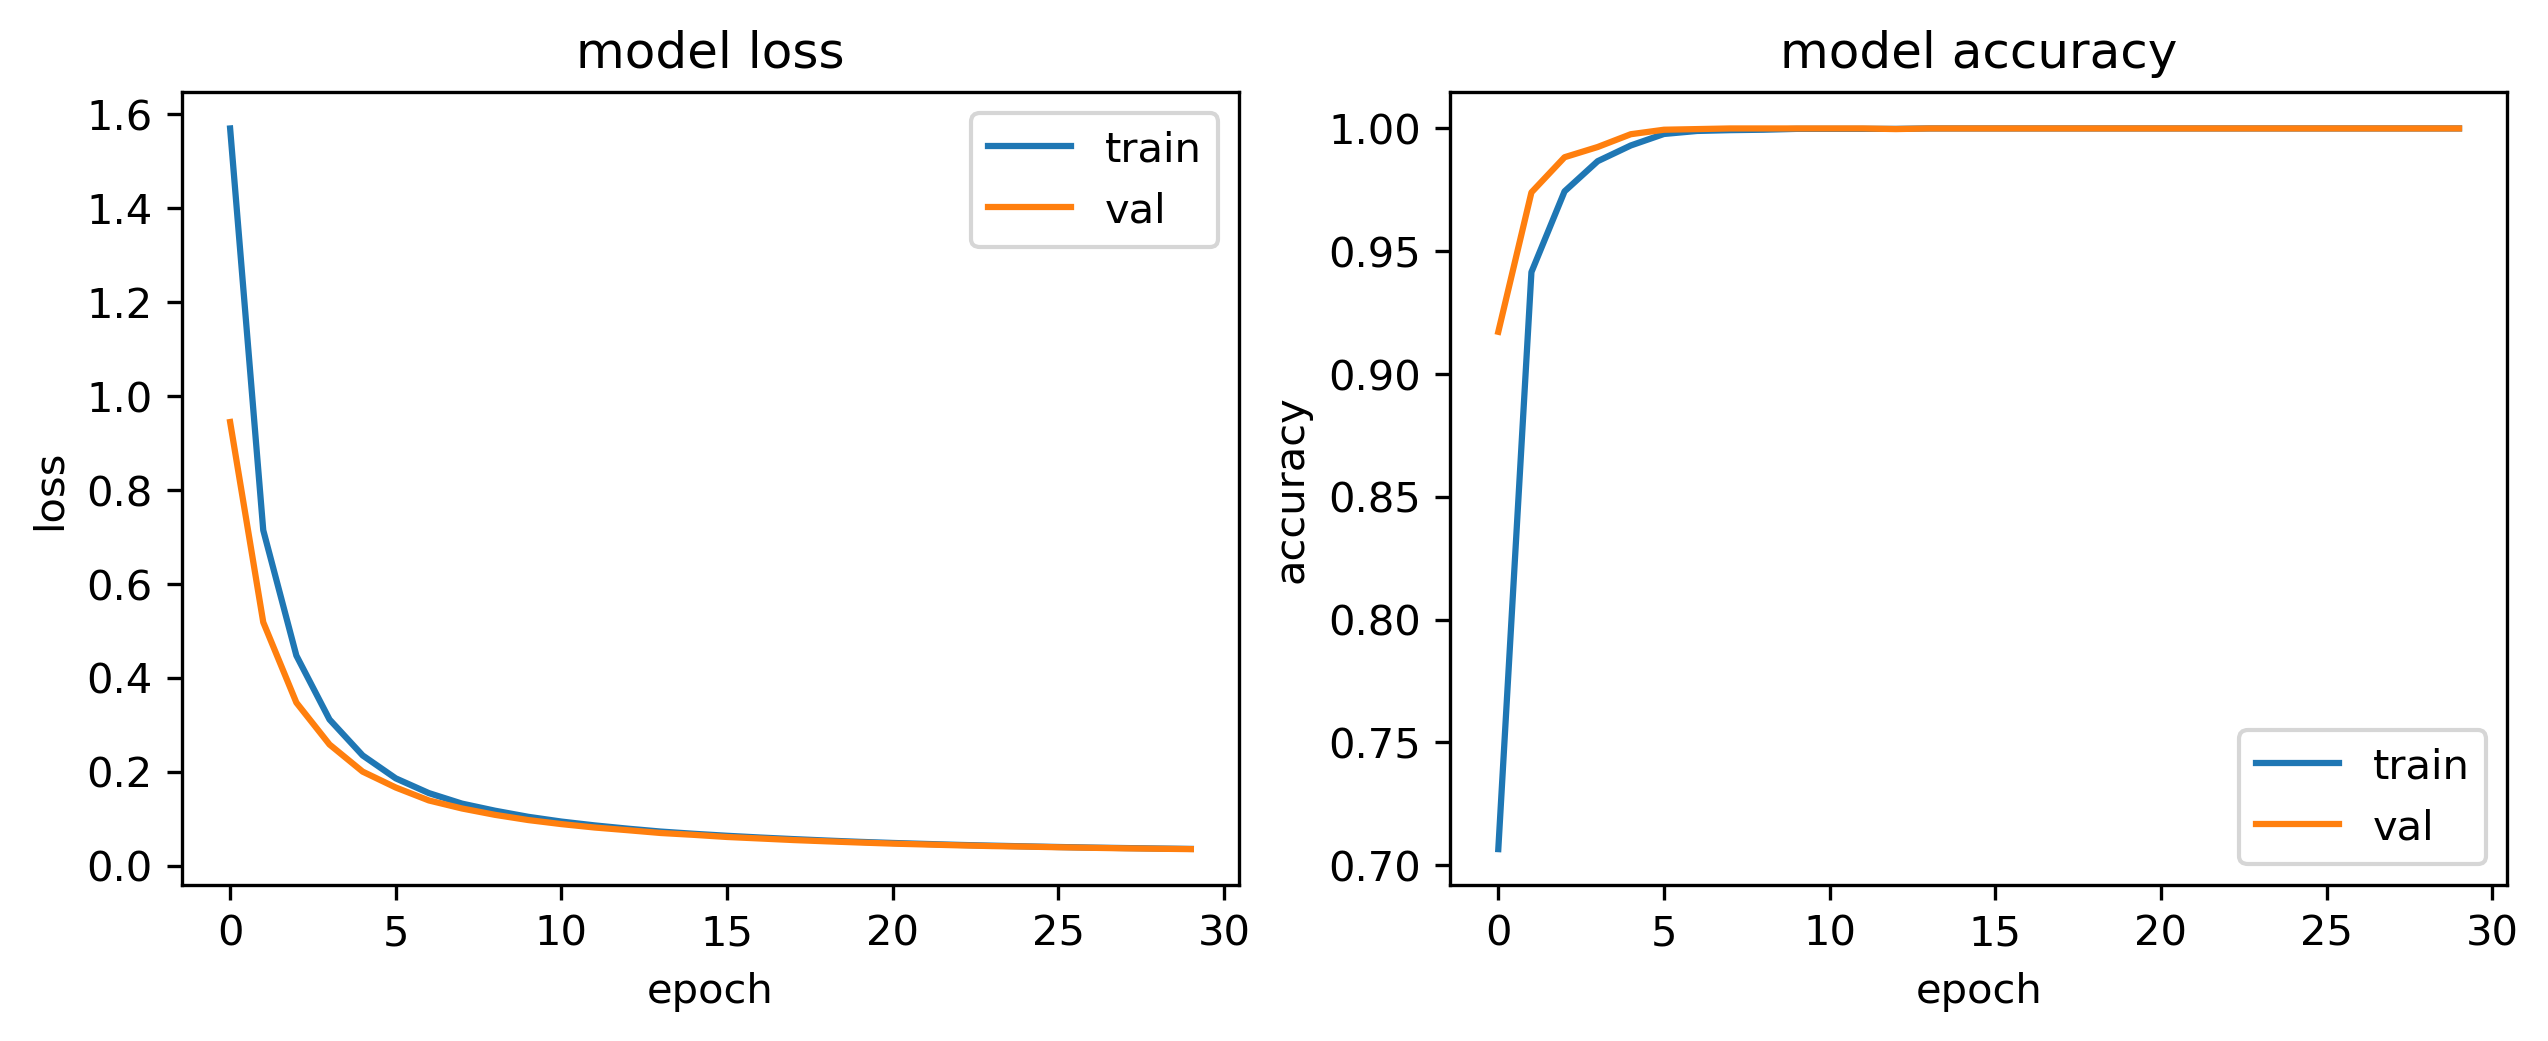

In [11]:
 # 绘制loss和acc曲线
def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')
    
PlotLoss('malconv_random', history)

In [12]:
# 进行模型保存
model.save('../model/malconv_random.h5')

In [13]:
# 测试2018数据集
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_random.h5')
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_2), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_2[idx:idx+batch_size], labels_2[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 68/68 [00:01<00:00, 36.06it/s]
              precision    recall  f1-score   support

    backdoor     0.9497    0.9795    0.9644       732
        worm     0.9741    0.9686    0.9713       700
       virus     0.9705    0.9705    0.9705       677
      trojan     0.9870    0.9535    0.9700       559

    accuracy                         0.9689      2668
   macro avg     0.9703    0.9680    0.9690      2668
weighted avg     0.9692    0.9689    0.9689      2668



In [14]:
# 批量预测2019数据集
batch_size = 100
for idx in range(0, len(data_path_3), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_3[idx:idx+batch_size], labels_3[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 78/78 [00:02<00:00, 31.59it/s]
              precision    recall  f1-score   support

    backdoor     0.9368    0.9825    0.9591      1026
        worm     0.9685    0.9741    0.9713      1041
       virus     0.9859    0.9589    0.9722      1021
      trojan     0.9843    0.9494    0.9665       790

    accuracy                         0.9673      3878
   macro avg     0.9689    0.9662    0.9673      3878
weighted avg     0.9679    0.9673    0.9673      3878



In [15]:
# 训练数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_random.h5')

# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_1), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_1[idx:idx+batch_size], labels_1[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=6))

100%|██████████| 29/29 [00:00<00:00, 43.54it/s]
              precision    recall  f1-score   support

    backdoor   1.000000  1.000000  1.000000      1842
        worm   1.000000  1.000000  1.000000      1859
       virus   1.000000  1.000000  1.000000      1761
      trojan   1.000000  1.000000  1.000000      1467

    accuracy                       1.000000      6929
   macro avg   1.000000  1.000000  1.000000      6929
weighted avg   1.000000  1.000000  1.000000      6929

